<a href="https://colab.research.google.com/github/Amritha07dec/MCN/blob/main/Neural_Network_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import torch
#import torch.nn as nn
#from torch.utils.data import Dataset, DataLoader
#import numpy as np

# Step 1: Padding function

#def pad_samples(raw_samples, target_dim=6):
#    padded = []
#    for ts in raw_samples:
#        pad_width = target_dim - ts.shape[1]
#        if pad_width > 0:
#            ts = np.pad(ts, ((0, 0), (0, pad_width)), mode='constant')
#        padded.append(ts)
#    return np.array(padded)

# Step 2: Dataset class

#class TimeSeriesDataset(Dataset):
#    def __init__(self, samples, labels):
#        self.samples = torch.tensor(samples, dtype=torch.float32)
#        self.labels = torch.tensor(labels, dtype=torch.long)

#    def __len__(self):
#        return len(self.samples)

#    def __getitem__(self, idx):
#        return self.samples[idx], self.labels[idx]

# Step 3: LSTM model


#class LSTMClassifier(nn.Module):
#    def __init__(self, input_size=6, hidden_size=64, num_layers=1, num_classes=4):
#        super(LSTMClassifier, self).__init__()
#        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size, num_classes)

#    def forward(self, x):
#        _, (h_n, _) = self.lstm(x)
#        out = self.fc(h_n[-1])
#        return out

# Step 4: Training loop


#def train(model, dataloader, criterion, optimizer, epochs=10):
#    model.train()
#    for epoch in range(epochs):
#        total_loss = 0.0
#        correct = 0
#       total = 0

#        for inputs, targets in dataloader:
#            optimizer.zero_grad()
#            outputs = model(inputs)
#            loss = criterion(outputs, targets)
#            loss.backward()
#            optimizer.step()

#            total_loss += loss.item()
#            _, predicted = torch.max(outputs, 1)
#            correct += (predicted == targets).sum().item()
#            total += targets.size(0)
#
#        acc = 100 * correct / total
#        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Padding function
def pad_samples(raw_samples, target_dim=6):
    padded = []
    for ts in raw_samples:
        pad_width = target_dim - ts.shape[1]
        if pad_width > 0:
            ts = np.pad(ts, ((0, 0), (0, pad_width)), mode='constant')
        padded.append(ts)
    return np.array(padded)

# Step 2: Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Step 3: LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=1, num_classes=4):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Step 4: Split the data into train and validation sets
def split_data(samples, labels, test_size=0.2):
    return train_test_split(samples, labels, test_size=test_size, random_state=42)

# Step 5: Training loop
def train(model, dataloader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

         # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

# Step 6: Validation loop
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = 100 * correct / total
    return total_loss / len(val_loader), accuracy


# Step 7: Plot confusion matrix
def plot_confusion_matrix(model, dataloader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
# 5. Simulate dummy data
#np.random.seed(42)
#torch.manual_seed(42)

#raw_samples = [np.random.rand(10000, np.random.choice([2, 3, 4, 5, 6])) for _ in range(450)]
#labels = np.random.randint(0, 4, size=(450,))

#X = pad_samples(raw_samples, target_dim=6)

#dataset = TimeSeriesDataset(X, labels)
#dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

#model = LSTMClassifier(input_size=6)
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train(model, dataloader, criterion, optimizer, epochs=5)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile

zip_path = '/content/drive/MyDrive/sample_generation/resample 476.zip'
extract_folder = '/content/unzipped_ode_simulations'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [6]:
import os
import pickle

# Replace this with your actual folder path inside Google Drive
folder_path = '/content/unzipped_ode_simulations'


In [7]:
import os
print(os.listdir(folder_path))


['Linear_3D_Coupled_Oscillators_Set-2_Deg-1_Params-0.5_0.5_0.5_IC-3.0_3.0_3.0.pkl', 'Van_der_Pol_Set-4_Deg-3_Params-20.0_IC-0.05_0.05.pkl', 'Rossler_Set-2_Deg-2_Params-0.1_0.1_6.0_IC-1.5_1.5_1.5.pkl', 'Van_der_Pol_Set-1_Deg-3_Params-0.5_IC--1.0_0.0.pkl', 'Linear_5D_Coupled_Oscillators_Set-1_Deg-1_Params-1.0_1.0_1.0_1.0_1.0_IC-0.75_0.0_0.0_0.0_0.0.pkl', 'Van_der_Pol_Set-4_Deg-3_Params-20.0_IC-0.30000000000000004_0.30000000000000004.pkl', 'Linear_3D_Coupled_Oscillators_Set-1_Deg-1_Params-1.0_1.0_1.0_IC--0.75_0.0_0.0.pkl', 'Lorenz96_Set-2_Deg-2_Params-12.0_6_IC-3.0_1.5_1.5_1.5_3.0_0.0.pkl', 'Duffing_Oscillator_Set-2_Deg-3_Params-0.2_1.0_0.5_0.8_1.0_IC-1.375_0.0.pkl', 'Lotka_Volterra_Cubic_Set-1_Deg-3_Params-1.0_0.5_0.1_1.0_0.1_IC-1.0_2.0.pkl', 'Linear_4D_Coupled_Oscillators_Set-1_Deg-1_Params-1.0_1.0_1.0_1.0_IC-0.0_0.0_0.0_0.0.pkl', 'Linear_2D_Harmonic_Oscillator_Set-1_Deg-1_Params-1.0_IC-2.0_0.0.pkl', 'Linear_4D_Coupled_Oscillators_Set-1_Deg-1_Params-1.0_1.0_1.0_1.0_IC-2.25_0.0_0.0_0.0.p

In [ ]:
time_series_list = []
labels = []
filenames = []

"""is it necessary for the neural network to have data  and labels in lists"""


for filename in os.listdir(folder_path):
    if filename.endswith('.pkl') or filename.endswith('.pickle'):
        print(f"Loading file: {filename}")  # 👈 This line shows the filename
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            sol = data["Time series"]  # shape: (10000, num_features)
            degree = data["degree"]    # class label: 0, 1, 2, or 3


             # Extract the actual array and shape it correctly
            sol_array = np.array(sol.y).T  # shape: (timesteps, features)
            time_series_list.append(sol_array)
            labels.append(degree)
            filenames.append(filename)

            #time_series_list.append(sol)
            #labels.append(degree)

print(f"Loaded {len(time_series_list)} samples.")
print(f"First sample shape: {time_series_list[0].shape}")
print(f"First label: {labels[0]}")



In [ ]:
labels[0:5]

In [ ]:
for i, ts in enumerate(time_series_list):
    print(f"Sample {i}: shape {ts.shape} filename: {filenames[i]}")



In [ ]:
#Code to detect non-matching shapes:

expected_timesteps = 10000  # The number of time steps you're expecting

for i, ts in enumerate(time_series_list):
    if ts.shape[0] != expected_timesteps:
        print(f"Sample {i}: shape {ts.shape}, file: {filenames[i]}")

In [ ]:
for i, ts in enumerate(time_series_list):
    if ts.shape[0] != expected_timesteps:
        file_to_delete = os.path.join(folder_path, filenames[i])
        print(f"Deleting: {file_to_delete}")
        os.remove(file_to_delete)

In [ ]:
time_series_list = []
labels = []
filenames = []


"""is it necessary for the neural network to have data  and labels in lists"""


for filename in os.listdir(folder_path):
    if filename.endswith('.pkl') or filename.endswith('.pickle'):
        print(f"Loading file: {filename}")    #This line shows the filename
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            sol = data["Time series"]  # shape: (10000, num_features)
            degree = data["degree"]    # class label: 0, 1, 2, or 3

             # Extract the actual array and shape it correctly
            sol_array = np.array(sol.y).T  # shape: (timesteps, features)
            time_series_list.append(sol_array)
            labels.append(degree)
            filenames.append(filename)

            #time_series_list.append(np.array(sol))
            #time_series_list.append(sol)  # No need to wrap again


            #labels.append(degree)

print(f"Loaded {len(time_series_list)} samples.")
print(f"First sample shape: {time_series_list[0].shape}")
print(f"First label: {labels[0]}")







In [ ]:
for i, ts in enumerate(time_series_list):
    print(f"Sample {i}: shape {ts.shape} filename: {filenames[i]}")

Epoch 1/10 | Loss: 18.1129 | Accuracy: 44.57%
Validation Loss: 1.4159 | Validation Accuracy: 52.17%
Epoch 2/10 | Loss: 16.5361 | Accuracy: 58.15%
Validation Loss: 1.2890 | Validation Accuracy: 56.52%
Epoch 3/10 | Loss: 14.6968 | Accuracy: 61.14%
Validation Loss: 1.1409 | Validation Accuracy: 56.52%
Epoch 4/10 | Loss: 12.9506 | Accuracy: 61.41%
Validation Loss: 1.0242 | Validation Accuracy: 58.70%
Epoch 5/10 | Loss: 11.2272 | Accuracy: 63.32%
Validation Loss: 0.9231 | Validation Accuracy: 60.87%
Epoch 6/10 | Loss: 10.7051 | Accuracy: 64.40%
Validation Loss: 0.8933 | Validation Accuracy: 59.78%
Epoch 7/10 | Loss: 9.9942 | Accuracy: 68.48%
Validation Loss: 0.8229 | Validation Accuracy: 67.39%
Epoch 8/10 | Loss: 9.4610 | Accuracy: 71.20%
Validation Loss: 0.7769 | Validation Accuracy: 69.57%
Epoch 9/10 | Loss: 8.8365 | Accuracy: 72.83%
Validation Loss: 0.7536 | Validation Accuracy: 68.48%
Epoch 10/10 | Loss: 7.9834 | Accuracy: 73.10%
Validation Loss: 0.7020 | Validation Accuracy: 75.00%


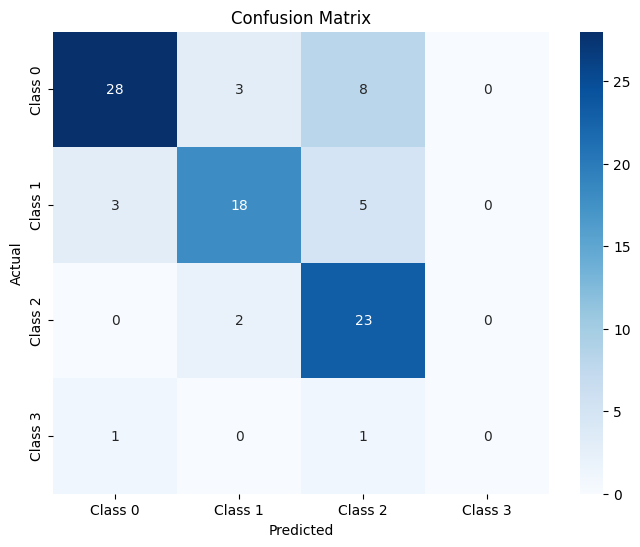

In [16]:
#Pad the samples before feeding into the neural network
padded_samples = pad_samples(time_series_list, target_dim=6)  # adjust if your target feature size is different

# Step 9: Split into training and validation sets
X_train, X_val, y_train, y_val = split_data(padded_samples, labels, test_size=0.2)

# create dataset and dataloader
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize your model loss and optimizer

model = LSTMClassifier(input_size=6, hidden_size=64, num_layers=1, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, dataloader, val_loader, criterion, optimizer, epochs=10)

# Plot confusion matrix on validation set
plot_confusion_matrix(model, val_loader)



In [ ]:
print(type(y_train))
print(y_train[:5])
